In [1]:
%load_ext autoreload
%autoreload 2
import os
import sys
#sys.path.append('/Users/danielburns/Library/CloudStorage/Box-Box/my_scripts')
from ChACRA.ContactAnalysis.ContactFrequencies import *
import warnings
warnings.filterwarnings("ignore")
import pandas as pd

In [ ]:
### Test new averaging

In [2]:
# getcontacts frequency files are all in here
frequency_dir = 'data/getcontacts_frequency_files'
# list them
frequency_files = [f'{frequency_dir}/{file}' for file in os.listdir(frequency_dir)]
# Now turn all the frequency data into a dictionary where each key is a contact id and
# each value is a list of contact frequencies across all the simulated temperatures
frequency_files.sort()
contact_frequency_dictionary = make_contact_frequency_dictionary(frequency_files)
# Now put this into a dataframe that the ContactFrequency class accepts
cont = ContactFrequencies(pd.DataFrame(contact_frequency_dictionary))

In [20]:
test = pd.read_csv(frequency_files[0],sep='\t',usecols=[0,1,2],skiprows=[0,1],header=None,names=['res1','res2','freq'],index_col=None)

In [26]:
test.loc[0]['res1']

'C:THR:680'

In [30]:
all_data = {}

for i, frequency_file in enumerate(frequency_files):
    test = pd.read_csv(frequency_file,sep='\t',usecols=[0,1,2],skiprows=[0,1],header=None,names=['res1','res2','freq'],index_col=None)
    for row in test.index:
        res1, res2, freq = test.loc[row]['res1'], test.loc[row]['res2'], test.loc[row]['freq']
        if f'{res1}-{res2}' not in all_data.keys():
            all_data[f'{res1}-{res2}'] = [0 for j in range(i)]
            all_data[f'{res1}-{res2}'].append(freq)
        else:
            extend_length = i - len(all_data[f'{res1}-{res2}'])-1
            all_data[f'{res1}-{res2}'].extend([0 for j in range(extend_length)])
            all_data[f'{res1}-{res2}'].append(freq)
for freq_list in all_data.values():
    if len(freq_list) != i+1:
        extend_length = i - len(all_data[f'{res1}-{res2}'])
        freq_list.extend(0 for j in range(extend_length))

In [29]:
test_cont = pd.DataFrame(all_data)
test_cont

ValueError: All arrays must be of the same length

In [3]:
# TRPV3 is a homotetramer so you can average the contact frequencies from all 4 subunits
# this will give better statistics on the contacts and simplify analysis
# adding a structure file is a good idea on a multimer so that when you go to visualize it,
# the correct contact pair is depicted.
avg_df = cont.average_contacts(structure='data/TRPV3_structure.pdb')
# pore contacts that occur between opposing subunits will print

False
Using subunit IDs A B C D for averaging.
Got more contacts than identical subunits for contact matching A:GLY:640-C:GLY:640. Maybe this is in a channel pore?
Got more contacts than identical subunits for contact matching A:ALA:675-B:ILE:674. Maybe this is in a channel pore?
Got more contacts than identical subunits for contact matching A:GLY:640-B:GLY:638. Maybe this is in a channel pore?
Got more contacts than identical subunits for contact matching A:ILE:674-D:ILE:674. Maybe this is in a channel pore?
Got more contacts than identical subunits for contact matching C:ASP:615-D:LYS:617. Maybe this is in a channel pore?
Got more contacts than identical subunits for contact matching B:ILE:674-C:LEU:670. Maybe this is in a channel pore?
Got more contacts than identical subunits for contact matching A:GLY:638-B:LEU:639. Maybe this is in a channel pore?
Got more contacts than identical subunits for contact matching A:GLU:682-D:GLU:679. Maybe this is in a channel pore?
Got more contacts

In [7]:
from ChACRA.ContactAnalysis.utils import *
from ChACRA.ContactAnalysis.contact_functions import _parse_id

In [54]:
u = mda.Universe('/home/kanaka/from_box/trp/7mij_renumber.pdb')
# adjust from 'PROA' naming 
for atom in u.atoms:
    atom.segment.segid = atom.segment.segid[-1]

In [63]:
equivalent_interactions

{('A', 'B'): [('A', 'B'), ('B', 'C'), ('C', 'D'), ('A', 'D')],
 ('A', 'C'): [('A', 'C'), ('B', 'D'), ('A', 'C'), ('B', 'D')],
 ('A', 'D'): [('A', 'D'), ('A', 'B'), ('B', 'C'), ('C', 'D')]}

In [62]:
#TODO progress bar
identical_subunits = find_identical_subunits(u)
df_copy = cont.freqs.copy()
# hold the averaged data
averaged_data = {}
# select one of each type of chain to be the representative chain for average naming
representative_chains = ['A']
# determine what the equivalent chain interactions relative to representative chains are for all the subunits
equivalent_interactions = get_equivalent_interactions(representative_chains,u)
# Retrieve/assign these from sorted identical subunits first indices.... although we want the other identical subunits first index to neighbor the chain in
# the first set... A needs to be next to G... This is the case for ATCASE - can just edit the chains in the PDB.... and produce a PDB for visualization along with averaging...
# identify priority name from each set of identical subunits

starting_length = len(df_copy.columns)

while len(df_copy.columns) > 0:
     resids = _parse_id(df_copy.columns[0])

     # find all of the other contacts that involve these residue names and numbers
     # intersubunit contacts can have swapped resids
     # so search with both regexes 
    
     regex = make_equivalent_contact_regex(resids)
     to_average = list(df_copy.filter(regex=regex, axis=1).columns)
     # now filter these to ensure you're only taking ones with equivalent_interaction names
     # chains should always be in alphabetical order
     chaina, chainb = resids['chaina'], resids['chainb']
     
     if chaina == chainb:
          identical_pair = True
     else:
          identical_pair = False

     representative_pair = get_representative_pair_name(chaina, chainb, identical_subunits, representative_chains, equivalent_interactions)
    


     
     # Can't deal the same with things ivolving a single subunit because not accounting for it in equivalent_interactions
     if identical_pair:
          averaged_name =  f"{representative_pair[0]}:{resids['resna']}:{resids['resida']}-{representative_pair[1]}:{resids['resnb']}:{resids['residb']}"
          to_drop = []
          for contact_name in to_average:
               contact_info = _parse_id(contact_name)
               # the chain equivalency check isn't necessary
               # but if if the chaina variable isn't in the same identical subunit group as the current contact's chain
               # drop it (that means it's happens to have the same resname and resnum but is happening on a different kind of subunit)
               if (contact_info['chaina'] not in identical_subunits[get_chain_group(chaina, identical_subunits)]):
                    to_drop.append(contact_name)
          for contact_name in to_drop:
               to_average.remove(contact_name)

     else:
          # if they're not identical and the first representative pair member matches is from the same identical subunit set as chaina
          # this only works for inter-hetero-subunit contacts NOT for inter-homo-subunit

          # inter-homo-subunit then need to first drop everything that involves the hetero-subunit
          to_drop = []
          resnums = []
          matched_name = None
          #REMOVE
          #flipped = None
          for contact_name in to_average:
               contact_info = _parse_id(contact_name)
               if (contact_info['chaina'],contact_info['chainb']) not in equivalent_interactions[representative_pair]:
                    to_drop.append(contact_name)
               # else: 
               #     # use this to identify the outlier that would give a flipped naming scheme
               #    resnums.append(contact_info['resida'])
                    
               if (contact_info['chaina'], contact_info['chainb']) == representative_pair:
                    matched_name = contact_name
                    # this doesn't make sense, comparing resids to chainids REMOVE
                    #elif (contact_info['residb'], contact_info['resida']) == representative_pair:
                         #flipped = True


          # drop the ones that don't fit the original pair
          for contact_name in to_drop:
               to_average.remove(contact_name)


          # if inter-hetero subunit     
          if get_chain_group(representative_pair[0], identical_subunits) != get_chain_group(representative_pair[1], identical_subunits):
               # and the order of the hetero subunit matches the representative_pairs, you can name it without further consideration 
               if get_chain_group(representative_pair[0], identical_subunits) ==  get_chain_group(resids['chaina'], identical_subunits):
                    averaged_name =  f"{representative_pair[0]}:{resids['resna']}:{resids['resida']}-{representative_pair[1]}:{resids['resnb']}:{resids['residb']}"
               # else:
               #      averaged_name =  f"{representative_pair[0]}:{resids['resnb']}:{resids['residb']}-{representative_pair[1]}:{resids['resna']}:{resids['resida']}"
          # it's inter-homo subunit
          else:
               # this should be the only case where you have to guess.. 
               # if the contact chains are the same as the representative pair, you eliminate one situation
               if matched_name is not None:
                    averaged_name = matched_name
               # elif flipped is not None:
               #      averaged_name = f"{representative_pair[0]}:{resids['resnb']}:{resids['residb']}-{representative_pair[1]}:{resids['resna']}:{resids['resida']}"
               else:
                    #measure the distance between the contacting residues for each contact
                    # can probably move this to top of the parent else (3rd back) when it originally iterates over to_average.  
                    contact_distances = []
                    for contact_name in to_average:
                         contact_info = _parse_id(contact_name)
                         sel1 = f"chainID {contact_info['chaina']} and resnum {contact_info['resida']} and name CA"
                         sel2 = f"chainID {contact_info['chainb']} and resnum {contact_info['residb']} and name CA"
                         contact_distances.append(get_pair_distance(sel1, sel2, u))

                    mean_distance = np.mean(contact_distances)

                    testa1 = f"chainID {representative_pair[0]} and resnum {contact_info['resida']} and name CA"
                    testa2 = f"chainID {representative_pair[1]} and resnum {contact_info['residb']} and name CA"
                    testb1 = f"chainID {representative_pair[1]} and resnum {contact_info['resida']} and name CA"
                    testb2 = f"chainID {representative_pair[0]} and resnum {contact_info['residb']} and name CA"

                    testa = get_pair_distance(testa1, testa2, u)
                    testb = get_pair_distance(testb1, testb2, u)
                    
                    # if the difference between the mean contact distance distance and the chain swapped one is greater....
                    if np.abs(testa-mean_distance) < np.abs(testb-mean_distance):
                         averaged_name = f"{representative_pair[0]}:{resids['resna']}:{resids['resida']}-{representative_pair[1]}:{resids['resnb']}:{resids['residb']}"
                    else:
                         # TODO Fix bad swap
                         averaged_name =  f"{representative_pair[0]}:{resids['resnb']}:{resids['residb']}-{representative_pair[1]}:{resids['resna']}:{resids['resida']}"
                    # now get both distances for the representative pair with resids swapped 
                    # and take the name that has the distance most closely matching the mean.
                    #compare_distances between the resids (and possibly all the others to get avg dist) and then the representative_pair and flipped representative_pair



         

         
         
     ## TODO adjust average to account for number of subunits
     #if chaina == chainb:
     #    denominator = len(identical_subunits(get_chain_group(chain)))
     #else:
     #  denominator = len(longest_identical_chain_group participating in intersubunit contact)
     averaged_data[averaged_name] = df_copy[to_average].sum(axis=1)/4
     df_copy.drop(to_average, axis=1, inplace=True)
     # report length of columns or percent remaining at intervals.
     if len(df_copy.columns)%10 == 0:
          print(len(df_copy.columns))

34390
34370
34350
34330
34310
34290
34270
34250
34230
34210
34190
34170
34150
34130
33640
33620
33600
33580
33560
33540
33520
33500
33480
33460
33440
33420
33390
33370
33350
33330
33300
33280
33260
33240
33220
33200
33180
33160
33140
33120
33100
33080
33060
33040
33020
32990
32970
32950
32930
31550
31530
31510
31490
31470
31450
31430
31410
31140
31120
31100
31080
31060
31030
31010
30990
30970
30950
30930
30910
30890
30870
30830
30810
30790
30770
30750
30730
30710
30690
30670
30650
30630
30610
30590
30570
30550
30530
30510
30490
30470
30450
30430
30410
30310
30290
30270
30250
30230
30210
30190
30170
30150
30130
30110
30090
30070
30050
30030
30010
29990
29970
29950
29070
29050
29030
29010
28990
28970
28950
28930
28910
28890
28870
28850
28830
28810
28790
28770
28750
28730
28710
28690
28670
28650
28630
28610
28590
28570
28550
27730
27710
27690
27670
27650
27630
27610
27590
27560
27540
27520
27500
27480
27460
27440
27420
27400
27380
26910
26890
26870
26850
26830
26810
26790
26770
26750
2673

In [64]:
new_avg = pd.DataFrame(averaged_data)

In [69]:
new_avg['A:MET:677-D:ALA:675']

0     0.62250
1     0.59525
2     0.57150
3     0.55750
4     0.53675
5     0.53325
6     0.51700
7     0.52300
8     0.53000
9     0.53300
10    0.55500
11    0.58500
12    0.59750
13    0.58950
14    0.58825
15    0.56825
16    0.55125
17    0.52725
18    0.52025
19    0.49475
20    0.43950
21    0.39475
22    0.36650
23    0.34500
24    0.33250
25    0.32050
26    0.32025
27    0.33275
Name: A:MET:677-D:ALA:675, dtype: float64

In [71]:
avg_df['A:MET:677-B:ALA:675']

0     0.62250
1     0.59525
2     0.57150
3     0.55750
4     0.53675
5     0.53325
6     0.51700
7     0.52300
8     0.53000
9     0.53300
10    0.55500
11    0.58500
12    0.59750
13    0.58950
14    0.58825
15    0.56825
16    0.55125
17    0.52725
18    0.52025
19    0.49475
20    0.43950
21    0.39475
22    0.36650
23    0.34500
24    0.33250
25    0.32050
26    0.32025
27    0.33275
Name: A:MET:677-B:ALA:675, dtype: float64

In [51]:
list(_parse_id(col).values())[3]

'A'

In [50]:
for col in avg_df.columns:
    if list(_parse_id(col).values())[3] not in ['A', 'B']:
        print(col)

In [66]:
not_equal = []
missed = []
for col in new_avg:
    try:
        if not np.allclose(new_avg[col].values, avg_df[col].values):
            print(col)
            not_equal.append(col)
    except:
        print(f"can't find {col}")
        missed.append(col)
        

can't find A:TYR:382-D:ASN:220
can't find A:THR:456-D:VAL:603
can't find A:GLU:751-D:ASN:178
A:ASN:643-A:ASP:641
can't find A:GLU:546-D:TYR:650
can't find A:PRO:753-D:PHE:249
can't find A:ILE:583-D:LEU:668
can't find A:PRO:384-D:PHE:259
can't find A:TRP:380-D:PHE:249
can't find A:MET:677-D:ALA:675
can't find A:ARG:462-D:SER:607
can't find A:VAL:552-D:ALA:604
can't find A:MET:572-D:PHE:592
can't find A:ARG:464-D:ILE:609
A:GLU:679-A:GLU:682
can't find A:TYR:460-D:SER:624
A:LEU:670-A:LEU:673
can't find A:GLU:751-D:LYS:174
can't find A:VAL:552-D:LEU:657
can't find A:LEU:553-D:LEU:653
can't find A:TRP:742-D:ARG:226
A:GLY:678-A:ILE:674
can't find A:ILE:579-D:MET:672
can't find A:ASN:735-D:HSD:256
can't find A:TYR:460-D:SER:607
can't find A:MET:677-D:MET:672
can't find A:LYS:634-D:ASP:641
can't find A:TYR:382-D:PHE:249
A:ASN:683-A:LYS:686
can't find A:PRO:753-D:TYR:213
can't find A:LYS:545-D:TYR:650
can't find A:TRP:742-D:THR:272
A:GLU:679-A:VAL:681
can't find A:GLU:751-D:LYS:169
can't find A

In [68]:
len(not_equal)

76

In [4]:
# make a list of the simulation temperatures and replace the index with the corresponding temperatures
nrep = 28
tmin = 300
tmax = 420
temps = []
for i in range(nrep):
    t=tmin*np.exp(i*np.log(tmax/tmin)/(nrep-1))
    temps.append(int(t))

tempsC = []
for C in temps:
    tempsC.append(round(C - 273.15))

avg_df.set_axis(tempsC, axis='index',inplace=True)

Text(0, 0.5, 'Projection')

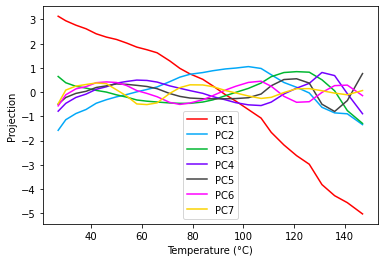

In [5]:
# Let's do PCA on this data and see what the first several PC projections look like
import matplotlib.pyplot as plt
pca = PCA(n_components=.99999)
pca.fit(avg_df)
pcs=pca.transform(avg_df)
fig, ax = plt.subplots()
colors = ['red','#02a8f8','#00b730','#7400ff','#434343','magenta','#fad300']
for i in range(len(colors)):
    ax.plot(tempsC, -1*pcs[:,i], color=colors[i])
ax.legend(['PC'+str(i+1) for i in range(len(colors))])
ax.set_xlabel('Temperature (°C)')
ax.set_ylabel('Projection')

PC 1 describes a melting trend where contact frequency decreases as temperature increases
PC 2 describes a trend of increasing order with temperature

In [6]:
# The ContactPCA class makes further analysis of the PCs easy
pca_data = ContactPCA(avg_df)

In [14]:
# Now we have a ContactPCA object that makes it easy to analyze the PCs
# If we sort the PCs according to absolute loading score value, we can see which contacts are the most temperature sensitive
# Let's see which residue interactions have the strongest tendency to melt
pca_data.sorted_norm_loadings(1)[['PC1']][:10]

,PC1
A:GLU:263-A:SER:294,1.000000
A:ASP:293-A:TYR:260,0.982246
A:ASP:293-A:GLU:263,0.979721
A:GLN:292-A:HSD:244,0.935146
A:ARG:295-A:ASN:339,0.826282
A:ASN:297-A:ASN:338,0.820465
A:GLY:329-A:LEU:325,0.812708
A:LYS:246-A:SER:294,0.793372
A:GLN:292-A:GLY:296,0.782837
A:ASN:297-A:ASP:293,0.782689


In [15]:
# We can also look at which contacts display the interesting behavior of increasing contact frequency with increasing temperature
pca_data.sorted_norm_loadings(2)[['PC2']][:10]

,PC2
A:LEU:508-A:THR:411,1.000000
A:GLY:638-A:GLY:640,0.881843
A:LEU:639-B:LEU:639,0.848288
A:ARG:712-A:ARG:716,0.746958
A:ARG:319-A:ASP:315,0.741226
A:HSD:471-A:SER:536,0.714558
A:ASP:396-A:THR:399,0.689065
A:PHE:522-A:TYR:564,0.681613
A:ASP:315-A:VAL:317,0.659613
A:GLY:638-B:GLY:638,0.637698


<AxesSubplot:>

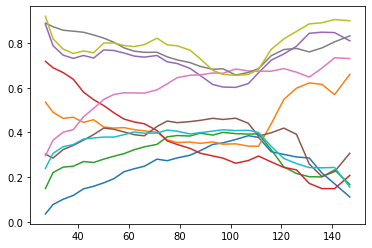

In [9]:
# We can go back to our original contact frequency data and plot these top contacts to see what their sign means
# Let's get the top 5 contacts on PC 2
contacts = pca_data.sorted_loadings(2)[['PC2']].index[:10]
avg_df[contacts].plot(legend=False)

In [10]:
# you can see that being positively correlated on PC 2 means a decreasing contact frequency through the lower temperature range
# Of course it's way more interesting to visualize this data on the protein itself.

In [11]:
from TSenCA.ContactAnalysis.contacts_to_pymol import *
cont_data = ContactFrequencies(avg_df)

In [12]:
to_visualize = []
for pc in range(1,8):
    to_visualize.extend(list(pca_data.sorted_norm_loadings(pc)[f'PC{pc}'].index)[:18])

In [13]:
to_pymol(to_visualize, cont_data, pca_data, 'trpv3_9985_test.pml',pc_range=(1,7))

In [16]:
pca_data.sorted_norm_loadings(6)['PC6'][:10]

A:ALA:474-A:THR:476    1.000000
A:ASP:315-A:VAL:317    0.801471
A:ALA:164-A:ASP:166    0.783047
A:ARG:567-A:THR:699    0.776036
A:ASP:586-A:THR:680    0.743606
A:HSD:477-A:PRO:470    0.722181
A:HSD:471-A:TYR:547    0.688989
A:ASN:242-A:GLN:286    0.682176
A:GLU:682-A:GLY:678    0.654357
A:LEU:473-A:TYR:540    0.650449
Name: PC6, dtype: float64